In [1]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files


In [2]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Install kaggle API and set it up for dataset download
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # Update path if necessary
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images

# Unzip dataset
!unzip -q indian-folk-art-gallery-high-resolution-images.zip -d /content/folk-art-dataset-main/


cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images
License(s): CC-BY-NC-SA-4.0
 98% 817M/837M [00:06<00:00, 177MB/s]
100% 837M/837M [00:06<00:00, 137MB/s]


In [5]:
# Path to dataset
image_dir = '/content/folk-art-dataset-main/folk-art-dataset-main'
IMG_SIZE = 128  # Resizing images for uniformity
images = []
image_labels = []

# Load images and labels
def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                try:
                    # Load and preprocess image
                    image = Image.open(img_path).convert('RGB')
                    image = image.resize((IMG_SIZE, IMG_SIZE))
                    images.append(np.array(image))
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Get labels and load images
labels = os.listdir(image_dir)
load_images(image_dir, labels)

# Convert to numpy arrays
images = np.array(images, dtype='float32') / 255.0  # Normalize images to [0, 1]
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])

# Convert labels to one-hot encoding
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)


In [8]:
# Load EfficientNetB0 as the base model
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom CNN head tailored to the output shape of base_model
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final output layer
output = Dense(len(label_to_num), activation='softmax')(x)

# Create the hybrid model
hybrid_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
hybrid_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Summary of the model
hybrid_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 128, 128, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 128, 128, 3)          0         ['normalization_2[0][0]'] 

In [9]:
# Train the hybrid model
history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# Save the trained model
hybrid_model.save('/content/drive/MyDrive/hybrid_cnn_folk_art_model.h5')


Epoch 1/20
808/808 [==============================] - 125s 147ms/step - loss: 3.4066 - accuracy: 0.0369 - val_loss: 3.4003 - val_accuracy: 0.0378
Epoch 2/20
808/808 [==============================] - 114s 141ms/step - loss: 3.3998 - accuracy: 0.0391 - val_loss: 3.4001 - val_accuracy: 0.0378
Epoch 3/20
808/808 [==============================] - 115s 142ms/step - loss: 3.3997 - accuracy: 0.0397 - val_loss: 3.4003 - val_accuracy: 0.0378
Epoch 4/20
808/808 [==============================] - 114s 141ms/step - loss: 3.3996 - accuracy: 0.0397 - val_loss: 3.4003 - val_accuracy: 0.0378
Epoch 5/20
808/808 [==============================] - 114s 142ms/step - loss: 3.3996 - accuracy: 0.0397 - val_loss: 3.4003 - val_accuracy: 0.0378
Epoch 6/20
808/808 [==============================] - 115s 143ms/step - loss: 3.3996 - accuracy: 0.0397 - val_loss: 3.4003 - val_accuracy: 0.0378
Epoch 7/20
808/808 [==============================] - 116s 144ms/step - loss: 3.3996 - accuracy: 0.0397 - val_loss: 3.4004 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


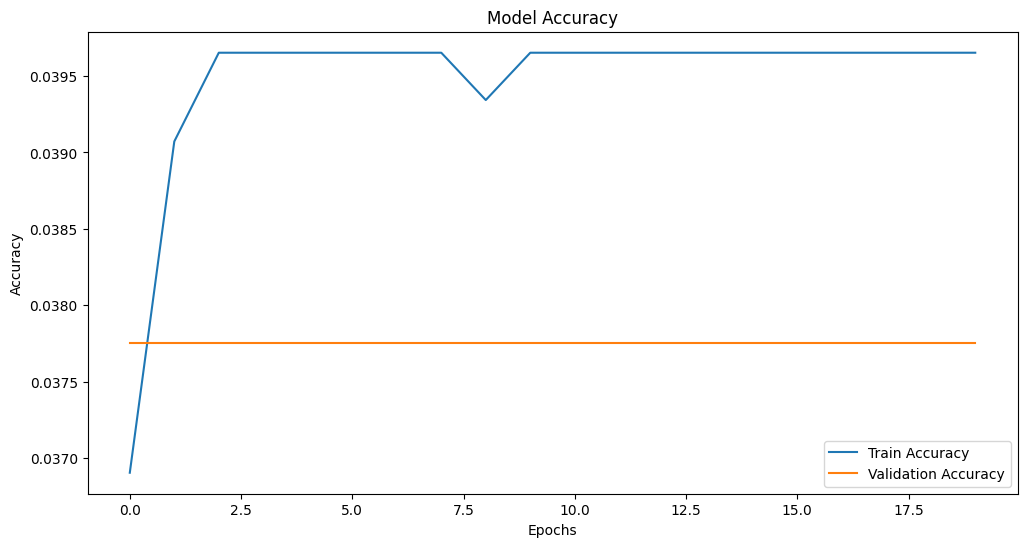

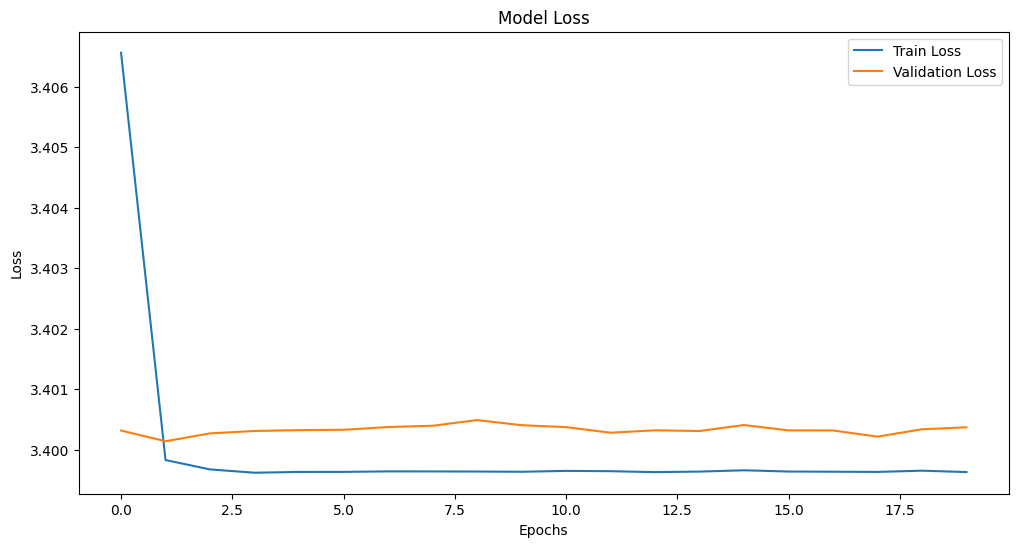

In [10]:
# Function to plot training accuracy and loss
def plot_accuracy_and_loss(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training performance
plot_accuracy_and_loss(history)


Saving 8.jpg to 8.jpg
1/1 [==============================] - 2s 2s/step


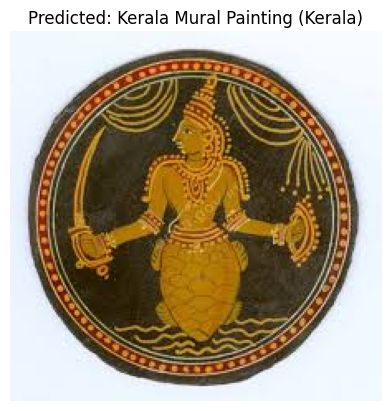

In [11]:
# Function to predict uploaded images
def predict_image(model, class_labels):
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = filename
        image = Image.open(img_path).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image = np.expand_dims(np.array(image) / 255.0, axis=0)  # Normalize and add batch dimension

        # Get predictions
        predictions = model.predict(image)
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_labels[predicted_class_idx]

        # Display prediction
        plt.imshow(Image.open(img_path))
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Test with user-uploaded images
predict_image(hybrid_model, list(label_to_num.keys()))
